In [1]:
# Importations nécessaires et configuration initiale
import os
import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from collections import Counter
from folium.plugins import MarkerCluster
from geopy.distance import geodesic
from IPython.display import display

In [2]:
import pandas as pd
import numpy as np
from skmob.preprocessing import detection
import skmob
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from similaritymeasures import dtw
from similaritymeasures import frechet_dist
from similaritymeasures import pcm
from similaritymeasures import area_between_two_curves
from hausdorff import hausdorff_distance
import time

In [3]:
df = pd.read_csv('C:/Users/marie/Downloads/uber.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
print(df.head())

   Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         

In [5]:
import pandas as pd

# 1. Renommer 'Unnamed: 0' en 'id' pour avoir un identifiant unique
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

# 2. Convertir 'pickup_datetime' en datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')  # 'coerce' pour éviter les erreurs si données mal formatées


# 4. Vérifier que les colonnes sont bien transformées
print(df.head())

# Optionnel : Afficher l'info du DataFrame pour vérifier les types
print(df.info())


         id                            key  fare_amount  \
0  24238194    2015-05-07 19:52:06.0000003          7.5   
1  27835199    2009-07-17 20:04:56.0000002          7.7   
2  44984355   2009-08-24 21:45:00.00000061         12.9   
3  25894730    2009-06-26 08:22:21.0000001          5.3   
4  17610152  2014-08-28 17:47:00.000000188         16.0   

            pickup_datetime  pickup_longitude  pickup_latitude  \
0 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         -73.96

In [6]:
df.shape

(200000, 9)

In [7]:
# Imputation par la médiane pour les valeurs manquantes
df['dropoff_longitude'].fillna(df['dropoff_longitude'].median(), inplace=True)
df['dropoff_latitude'].fillna(df['dropoff_latitude'].median(), inplace=True)

In [8]:
# Vérifier les valeurs manquantes restantes
print(df[['dropoff_longitude', 'dropoff_latitude']].isnull().sum())

dropoff_longitude    0
dropoff_latitude     0
dtype: int64


In [9]:
# Étape 4 : Création des trajectoires populaires
df['route'] = df.apply(lambda x: ((x['pickup_latitude'], x['pickup_longitude']),
                                  (x['dropoff_latitude'], x['dropoff_longitude'])), axis=1)
route_counts = Counter(df['route'])
top_routes = route_counts.most_common(50)

m = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
marker_cluster = MarkerCluster().add_to(m)

for route, count in top_routes:
    folium.PolyLine(route, color="blue", weight=count / 5, opacity=0.7).add_to(m)
    start_point = route[0]
    folium.Marker(location=start_point, icon=folium.Icon(color="green", icon="taxi", prefix="fa"),
                  popup=f"Départs fréquents (occurences: {count})").add_to(marker_cluster)
display(m)

In [10]:
df = df[(df['fare_amount'] > 0) & (df['fare_amount'] < 100)]

# Suppression des valeurs aberrantes pour les coordonnées GPS
# Limites approximatives de longitude et latitude pour New York
df = df[(df['pickup_longitude'] >= -74.25559) & (df['pickup_longitude'] <= -73.70001)]
df = df[(df['pickup_latitude'] >= 40.49612) & (df['pickup_latitude'] <= 40.91553)]
df = df[(df['dropoff_longitude'] >= -74.25559) & (df['dropoff_longitude'] <= -73.70001)]
df = df[(df['dropoff_latitude'] >= 40.49612) & (df['dropoff_latitude'] <= 40.91553)]

# Suppression des courses avec un nombre de passagers invalide
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194784 entries, 0 to 199999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   id                 194784 non-null  int64              
 1   key                194784 non-null  object             
 2   fare_amount        194784 non-null  float64            
 3   pickup_datetime    194784 non-null  datetime64[ns, UTC]
 4   pickup_longitude   194784 non-null  float64            
 5   pickup_latitude    194784 non-null  float64            
 6   dropoff_longitude  194784 non-null  float64            
 7   dropoff_latitude   194784 non-null  float64            
 8   passenger_count    194784 non-null  int64              
 9   route              194784 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(5), int64(2), object(2)
memory usage: 16.3+ MB


In [12]:
# Sélectionner un échantillon de 1000 lignes
df_sampled = df.sample(n=500, random_state=42)




In [13]:
df_selected = df_sampled[['id', 'pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude']].copy()


In [14]:
# Convertir la colonne 'id' en numérique (ici, on utilise pd.to_numeric())
df_selected['id'] = pd.to_numeric(df_selected['id'], errors='coerce')
# Assurez-vous que les colonnes 'longitude' et 'latitude' sont bien numériques
df_selected['pickup_longitude'] = pd.to_numeric(df_selected['pickup_longitude'], errors='coerce')
df_selected['pickup_latitude'] = pd.to_numeric(df_selected['pickup_latitude'], errors='coerce')
df_selected['dropoff_longitude'] = pd.to_numeric(df_selected['dropoff_longitude'], errors='coerce')
df_selected['dropoff_latitude'] = pd.to_numeric(df_selected['dropoff_latitude'], errors='coerce')


# Afficher le DataFrame échantillonné avec 'id' converti en numérique
print(df_selected)

              id  pickup_longitude  pickup_latitude  dropoff_longitude  \
159688  23554456        -73.991610        40.750087         -73.997919   
35761   32377800        -73.994907        40.760530         -73.992082   
170809  53681683        -73.993535        40.752368         -73.963247   
23087   23237724        -73.980607        40.754175         -73.984667   
60002   45424100        -73.983971        40.740932         -73.982264   
...          ...               ...              ...                ...   
153704  24306181        -73.945747        40.782830         -73.970420   
162446  46159740        -73.970521        40.747822         -73.979309   
41287   46647484        -73.983268        40.755060         -73.995184   
181464  43160261        -74.008299        40.737575         -74.003160   
180845  10481228        -73.990521        40.745633         -74.007453   

        dropoff_latitude  
159688         40.755447  
35761          40.751623  
170809         40.801938  
230

In [15]:
df_selected.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 159688 to 180845
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 500 non-null    int64  
 1   pickup_longitude   500 non-null    float64
 2   pickup_latitude    500 non-null    float64
 3   dropoff_longitude  500 non-null    float64
 4   dropoff_latitude   500 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 23.4 KB


In [16]:
def ajout_donnee(mesure,runtime,avg_silhouette_score) :
  d = {}
  d['mesure de similarité'] = mesure
  d['runtime'] = runtime
  d['avg_sihouette_score'] = avg_silhouette_score
  return 
ajout_donnee('dtw',1,33)
list_comparaison = []
length = len(list(df_selected['id'].unique()) )
length

500

In [17]:
manhattan_matrix = np.zeros((length,length))

In [18]:
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from hausdorff import hausdorff_distance
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Initialisation du temps
start_time = time.time()

# Initialiser la matrice de distances
n = len(df_selected['id'].unique())
manhattan_matrix = np.zeros((n, n))

# Récupérer les IDs uniques
id_list = df_selected['id'].unique()

i = 0
for uid_1 in id_list:
    j = 0
    # Sélectionner les colonnes numériques : longitude et latitude
    trajectory_1 = df_selected[df_selected['id'] == uid_1][['pickup_longitude', 'pickup_latitude']].values
    for uid_2 in id_list:
        trajectory_2 = df_selected[df_selected['id'] == uid_2][['pickup_longitude', 'pickup_latitude']].values
        # Vérifier que les données sont numériques
        if np.issubdtype(trajectory_1.dtype, np.number) and np.issubdtype(trajectory_2.dtype, np.number):
            manhattan_matrix[i][j] = hausdorff_distance(trajectory_1, trajectory_2, distance="manhattan")
        else:
            manhattan_matrix[i][j] = np.nan  # Remplacer par np.nan si la condition échoue
        j += 1
    i += 1

# Appliquer KMeans pour créer des labels de clusters (exemple avec 3 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(manhattan_matrix)

# Calcul du score de silhouette
sil_score = silhouette_score(manhattan_matrix, cluster_labels)

# Temps d'exécution
end_time = time.time()

# Affichage du temps d'exécution
print(f"Temps d'exécution : {end_time - start_time} secondes")

# Affichage du score de silhouette
print(f"Silhouette score moyen : {sil_score}")
print(manhattan_matrix)



c:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Temps d'exécution : 174.57876896858215 secondes
Silhouette score moyen : 0.46389396729264337
[[0.       0.01374  0.004206 ... 0.013315 0.029201 0.005543]
 [0.01374  0.       0.009534 ... 0.017109 0.036347 0.019283]
 [0.004206 0.009534 0.       ... 0.012959 0.029557 0.009749]
 ...
 [0.013315 0.017109 0.012959 ... 0.       0.042516 0.01668 ]
 [0.029201 0.036347 0.029557 ... 0.042516 0.       0.025836]
 [0.005543 0.019283 0.009749 ... 0.01668  0.025836 0.      ]]


In [19]:
manhattan_runtime = end_time - start_time
manhattan_runtime

174.57876896858215

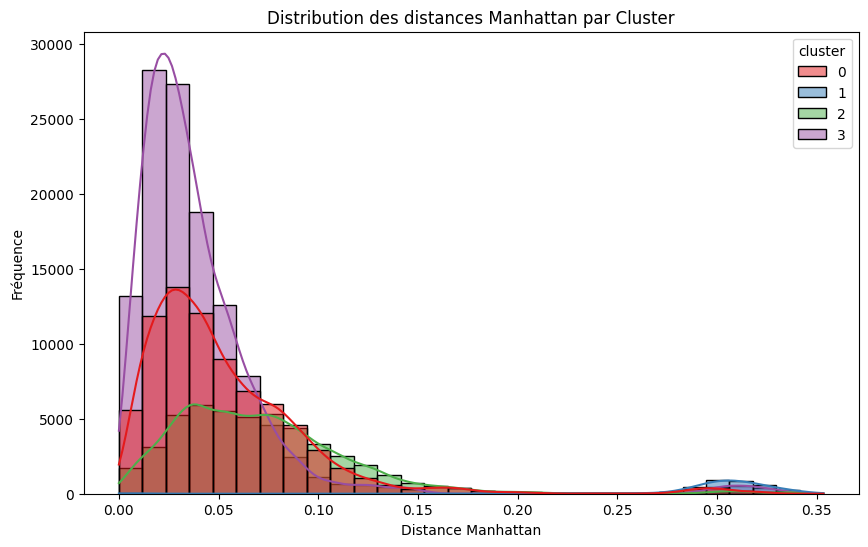

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Aplatir la matrice de distances
manhattan_flat = manhattan_matrix.flatten()
cluster_labels_flat = np.repeat(cluster_labels, n)

# Créer un DataFrame pour les distances et les labels de clusters
df_manhattan = pd.DataFrame({
    'distance': manhattan_flat,
    'cluster': cluster_labels_flat
})

# Supprimer les NaN
df_manhattan = df_manhattan.dropna()

# --- Histogramme des distances Manhattan par cluster ---
plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_manhattan,
    x='distance',
    hue='cluster',
    kde=True,  # Ajouter une courbe de densité
    palette='Set1',
    bins=30  # Choisir un nombre raisonnable de bacs pour l'histogramme
)
plt.title('Distribution des distances Manhattan par Cluster')
plt.xlabel('Distance Manhattan')
plt.ylabel('Fréquence')
plt.show()


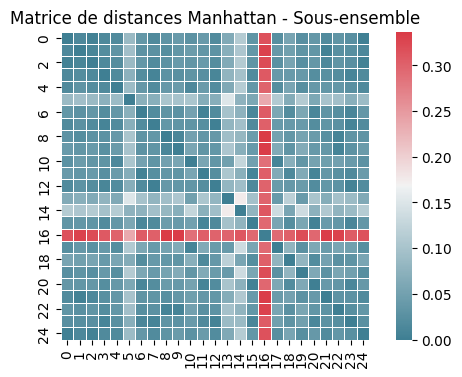

In [21]:
# Limiter à un sous-ensemble de la matrice pour l'affichage
subset_size = 25 # Afficher un sous-ensemble de 20 utilisateurs
subset_matrix = manhattan_matrix[:subset_size, :subset_size]

# Tracer la heatmap pour le sous-ensemble
f, ax = plt.subplots(figsize=(7, 4))
sns.heatmap(subset_matrix,
            cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            square=True, ax=ax, linewidths=.5)
plt.title('Matrice de distances Manhattan - Sous-ensemble')
plt.show()

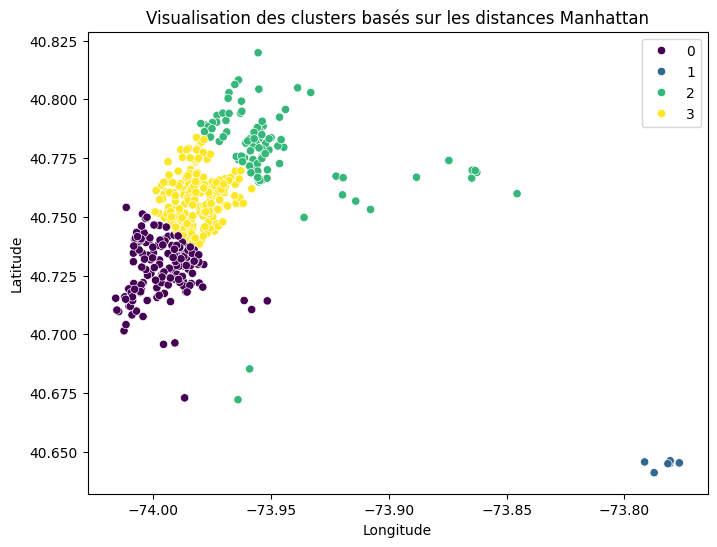

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Visualisation des clusters avec les coordonnées de pickup (longitude, latitude)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_selected['pickup_longitude'],
    y=df_selected['pickup_latitude'],
    hue=cluster_labels,  # Utiliser les labels de clusters générés par KMeans
    palette="viridis",  # Palette de couleurs, ajustable
    legend='full',  # Afficher la légende
    marker='o'
)
plt.title("Visualisation des clusters basés sur les distances Manhattan")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


In [23]:
#pcm

In [24]:
pcm_matrix = np.zeros((length,length))

In [25]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Définir ou importer la fonction PCM (exemple simplifié)
def pcm(traj1, traj2):
    return np.linalg.norm(traj1 - traj2)  # Exemple : distance euclidienne (à remplacer par ta fonction réelle)

start_time = time.time()

# Initialiser la matrice de distances PCM
n = len(df_selected['id'].unique())  # Nombre d'identifiants uniques
pcm_matrix = np.zeros((n, n))  # Matrice carrée (n x n)

# Liste des identifiants uniques
id_list = df_selected['id'].unique()

# Calcul de la matrice des distances PCM
for i in range(n):
    trajectory_1 = df_selected[df_selected['id'] == id_list[i]][['pickup_longitude', 'pickup_latitude']].values
    
    for j in range(i, n):  # Calcul uniquement pour la moitié supérieure
        trajectory_2 = df_selected[df_selected['id'] == id_list[j]][['pickup_longitude', 'pickup_latitude']].values
        
        if trajectory_1.size > 0 and trajectory_2.size > 0:
            distance = pcm(trajectory_1, trajectory_2)
            pcm_matrix[i][j] = distance
            pcm_matrix[j][i] = distance  # Symétrie
        else:
            pcm_matrix[i][j] = pcm_matrix[j][i] = np.nan

# Appliquer KMeans pour créer des labels de clusters (exemple avec 4 clusters)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(np.nan_to_num(pcm_matrix))  # Remplacer NaN par 0 pour KMeans

# Calcul du score de silhouette pour évaluer la qualité des clusters
sil_score = silhouette_score(pcm_matrix, cluster_labels, metric='precomputed')

# Temps d'exécution
end_time = time.time()

# Affichage des résultats
print(f"Score de silhouette moyen : {sil_score:.4f}")
print(pcm_matrix)



Score de silhouette moyen : 0.6021
[[0.         0.01095109 0.00298473 ... 0.00971183 0.0208584  0.0045852 ]
 [0.01095109 0.         0.00827651 ... 0.0128603  0.02657589 0.01552925]
 [0.00298473 0.00827651 0.         ... 0.01061405 0.02089997 0.00737865]
 ...
 [0.00971183 0.0128603  0.01061405 ... 0.         0.0305332  0.0118943 ]
 [0.0208584  0.02657589 0.02089997 ... 0.0305332  0.         0.01951893]
 [0.0045852  0.01552925 0.00737865 ... 0.0118943  0.01951893 0.        ]]


c:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


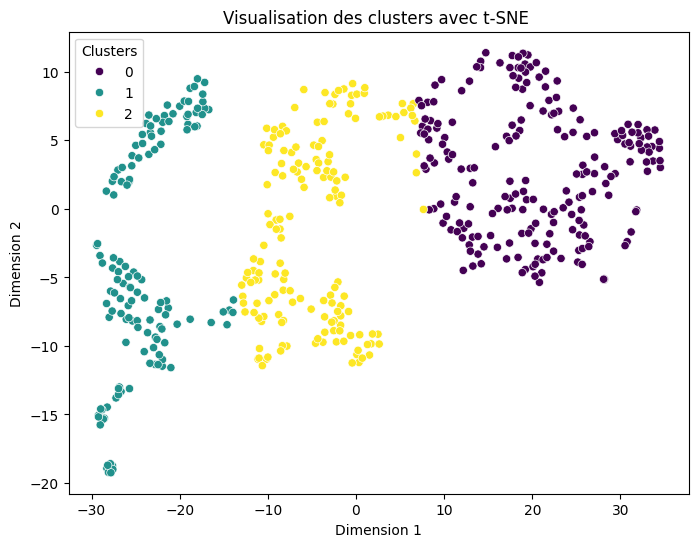

In [26]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Réduction de dimension avec t-SNE pour la matrice de distances
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42)
reduced_data = tsne.fit_transform(pcm_matrix)

kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_data)  # Appliquer le KMeans sur les données réduites

# Visualisation des clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=cluster_labels, palette='viridis', marker='o')
plt.title("Visualisation des clusters avec t-SNE ")
# Dimension 1 : Représente la projection des données le long de l'axe horizontal du graphique.
 #Dimension 2 : Représente la projection des données le long de l'axe vertical
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title='Clusters')
plt.show()


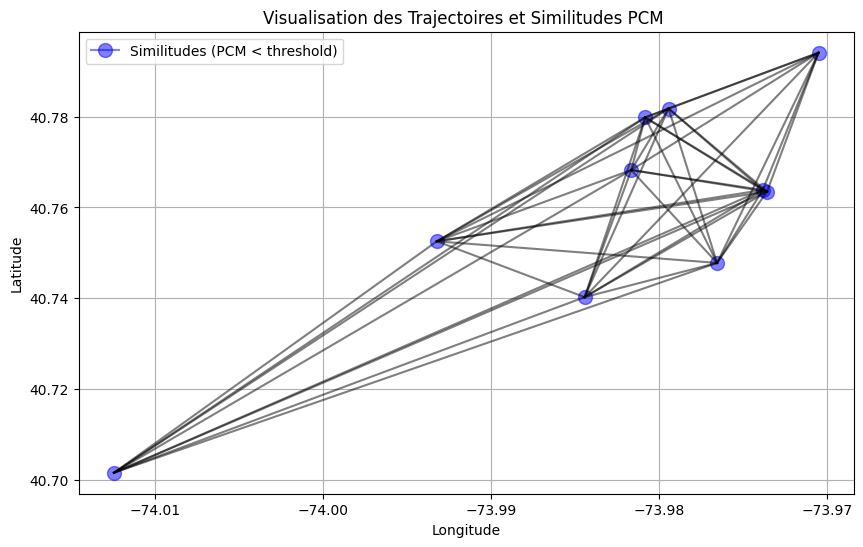

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour afficher un échantillon de trajectoires et leurs similitudes PCM
def plot_trajectories_and_similarities_sampled(df_selected, id_list, pcm_matrix, sample_size=10, threshold=0.1, alpha=0.5, marker_size=5):
    # Sélectionner un échantillon aléatoire d'id_list
    sampled_ids = np.random.choice(id_list, size=sample_size, replace=False)

    plt.figure(figsize=(10, 6))

    # Visualisation des trajectoires échantillonnées
    for trajectory_id in sampled_ids:
        # Sélectionner les coordonnées des trajectoires (longitude, latitude)
        coords = df_selected[df_selected['id'] == trajectory_id][['pickup_longitude', 'pickup_latitude']].values
        plt.plot(coords[:, 0], coords[:, 1], marker='o', alpha=alpha, color='b', markersize=marker_size)  # Augmenter la taille des marqueurs

    # Ajouter des lignes pour les trajectoires similaires dans l'échantillon
    for i in range(len(sampled_ids)):
        for j in range(i + 1, len(sampled_ids)):  # Comparer uniquement la moitié supérieure de la matrice
            # Trouver l'indice correspondant dans la matrice PCM
            idx_i = np.where(id_list == sampled_ids[i])[0][0]
            idx_j = np.where(id_list == sampled_ids[j])[0][0]

            # Récupérer la distance PCM entre les deux trajectoires
            distance = pcm_matrix[idx_i, idx_j]
            if not np.isnan(distance) and distance < threshold:  # Trajectoires similaires
                traj_i_coords = df_selected[df_selected['id'] == sampled_ids[i]][['pickup_longitude', 'pickup_latitude']].values
                traj_j_coords = df_selected[df_selected['id'] == sampled_ids[j]][['pickup_longitude', 'pickup_latitude']].values
                
                # Tracer une ligne entre les trajectoires similaires
                plt.plot([traj_i_coords[0, 0], traj_j_coords[0, 0]], 
                         [traj_i_coords[0, 1], traj_j_coords[0, 1]], 'k-', alpha=0.5)

    # Ajouter un titre et des labels
    plt.title(f"Visualisation des Trajectoires et Similitudes PCM ")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # Ajouter un seuil pour la légende des lignes de similitude
    plt.legend(["Similitudes (PCM < threshold)"], loc="upper left")
    plt.grid(True)
    plt.show()

# Appeler la fonction avec les paramètres appropriés
plot_trajectories_and_similarities_sampled(df_selected, id_list, pcm_matrix, sample_size=10, marker_size=10)  # Par exemple, échantillon de 10 trajectoires


In [28]:
#distance euclidienne 

In [29]:
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans  # Par exemple, pour appliquer un clustering KMeans

# Définir la fonction pour calculer la distance Euclidienne
def euclidean_distance(traj1, traj2):
    # Calculer la distance Euclidienne entre deux trajectoires
    return np.linalg.norm(traj1 - traj2)

# Initialiser la matrice de distances Euclidienne
n = len(df_selected['id'].unique())  # Nombre d'identifiants uniques
euclidean_matrix = np.zeros((n, n))  # Matrice carrée (n x n)

# Liste des identifiants uniques
id_list = df_selected['id'].unique()

# Calcul de la matrice des distances Euclidiennes
for i in range(n):
    trajectory_1 = df_selected[df_selected['id'] == id_list[i]][['pickup_longitude', 'pickup_latitude']].values

    for j in range(i, n):  # Calcul uniquement pour la moitié supérieure
        trajectory_2 = df_selected[df_selected['id'] == id_list[j]][['pickup_longitude', 'pickup_latitude']].values

        if trajectory_1.size > 0 and trajectory_2.size > 0:
            distance = euclidean_distance(trajectory_1, trajectory_2)
            euclidean_matrix[i][j] = distance
            euclidean_matrix[j][i] = distance  # Symétrie
        else:
            euclidean_matrix[i][j] = euclidean_matrix[j][i] = np.nan

# Affichage de la matrice de distances Euclidiennes
print("Matrice de distances Euclidiennes :")
print(euclidean_matrix)

# Clustering KMeans (exemple avec 3 clusters)
kmeans = KMeans(n_clusters=3, random_state=42)
# Appliquer KMeans sur les coordonnées de latitude et longitude
coordinates = df_selected[['pickup_longitude', 'pickup_latitude']].values
kmeans.fit(coordinates)

# Calcul du score de silhouette moyen
silhouette_avg = silhouette_score(coordinates, kmeans.labels_)
print(f"Score de silhouette moyen : {silhouette_avg}")


Matrice de distances Euclidiennes :
[[0.         0.01095109 0.00298473 ... 0.00971183 0.0208584  0.0045852 ]
 [0.01095109 0.         0.00827651 ... 0.0128603  0.02657589 0.01552925]
 [0.00298473 0.00827651 0.         ... 0.01061405 0.02089997 0.00737865]
 ...
 [0.00971183 0.0128603  0.01061405 ... 0.         0.0305332  0.0118943 ]
 [0.0208584  0.02657589 0.02089997 ... 0.0305332  0.         0.01951893]
 [0.0045852  0.01552925 0.00737865 ... 0.0118943  0.01951893 0.        ]]
Score de silhouette moyen : 0.44341763506355214


c:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


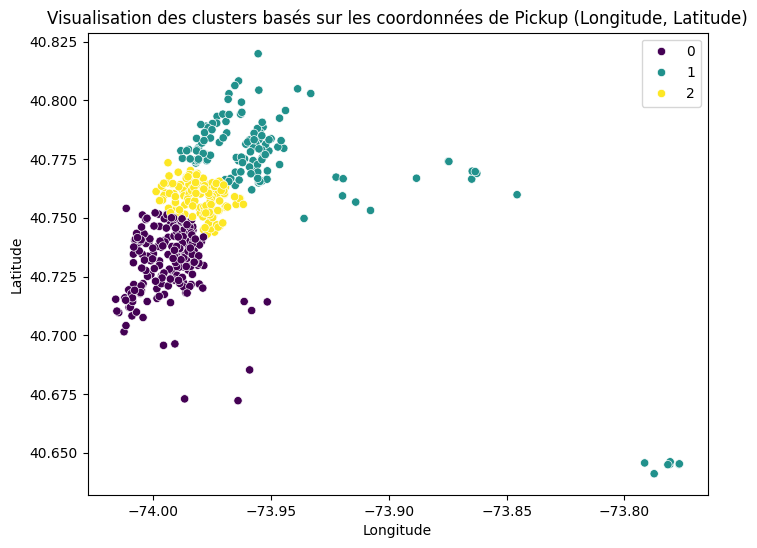

In [30]:
# Visualisation des clusters avec les coordonnées de pickup (longitude, latitude)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_selected['pickup_longitude'],
    y=df_selected['pickup_latitude'],
    hue=cluster_labels,
    palette="viridis",  # Changer la palette de couleurs si nécessaire
    legend='full',
    marker='o'
)
plt.title("Visualisation des clusters basés sur les coordonnées de Pickup (Longitude, Latitude)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



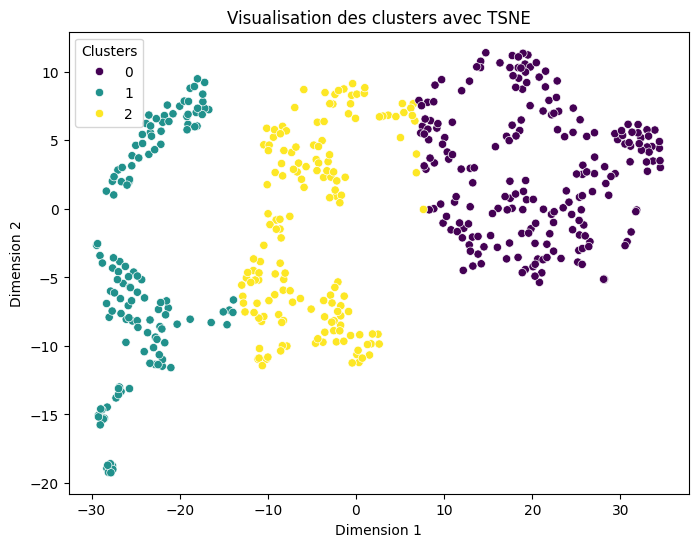

In [31]:
from sklearn.manifold import TSNE

# Réduction de dimension avec TSNE pour la matrice de distances
tsne = TSNE(n_components=2, metric='precomputed', init='random', random_state=42)  # init='random' à la place de 'pca'
reduced_data = tsne.fit_transform(pcm_matrix)

# Visualisation des clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=cluster_labels, palette='viridis', marker='o')
plt.title("Visualisation des clusters avec TSNE")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title='Clusters')
plt.show()


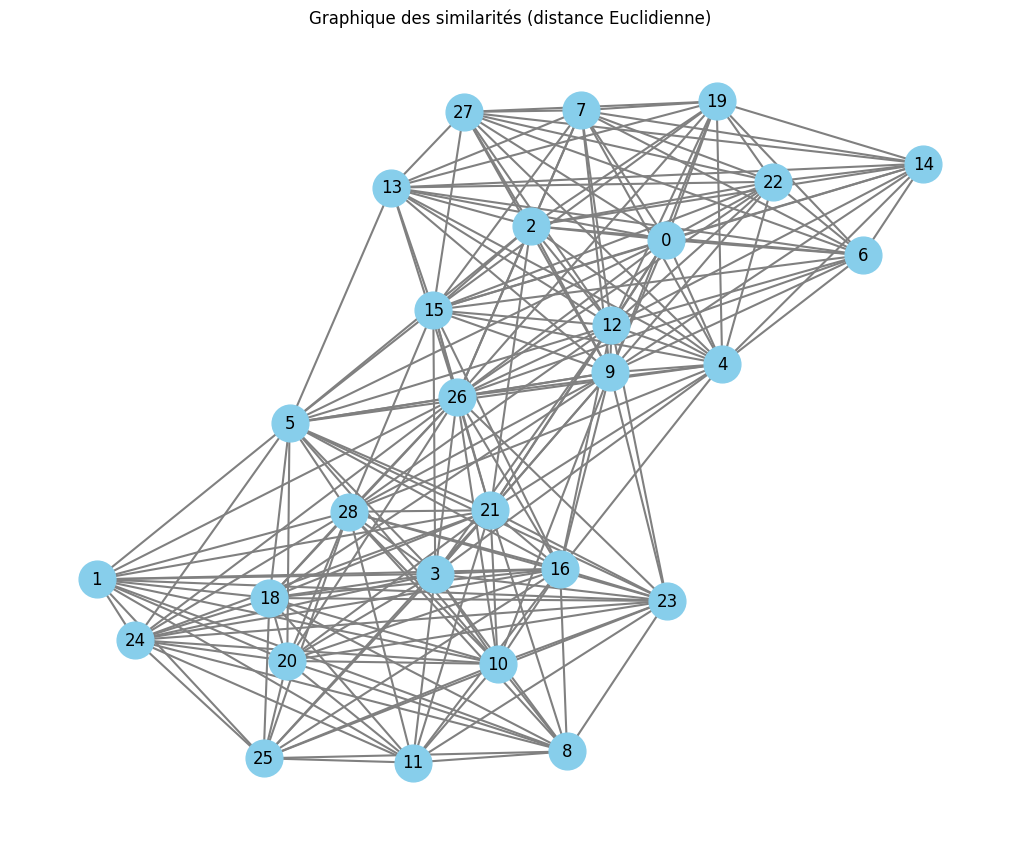

In [32]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Fonction pour calculer la distance Euclidienne entre deux points
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Définir la taille de l'échantillon (par exemple, 15 nœuds)
sample_size = 30
indices = np.random.choice(len(df_selected), sample_size, replace=False)  # Tirage aléatoire sans répétition

# Sous-échantillonner les données (par exemple, latitude et longitude des points)
data_sample = df_selected.iloc[indices][['pickup_longitude', 'pickup_latitude']].values

# Calculer la matrice de distances Euclidiennes
euclidean_matrix = np.zeros((sample_size, sample_size))  # Matrice carrée (sample_size x sample_size)

for i in range(sample_size):
    for j in range(i + 1, sample_size):
        distance = euclidean_distance(data_sample[i], data_sample[j])
        euclidean_matrix[i, j] = distance
        euclidean_matrix[j, i] = distance  # Symétrie de la distance

# Calculer un seuil basé sur la médiane de la matrice de distances
seuil = np.median(euclidean_matrix[np.triu_indices(sample_size, k=1)])

# Créer un graphe basé sur la matrice de distances Euclidiennes sous-échantillonnée
G = nx.Graph()
for i in range(sample_size):
    for j in range(i + 1, sample_size):
        if euclidean_matrix[i][j] < seuil:
            G.add_edge(i, j, weight=euclidean_matrix[i][j])

# Dessiner le graphe simplifié
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Disposition du graphe
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray', width=1.5)
plt.title("Graphique des similarités (distance Euclidienne)")
plt.show()


In [33]:
#chebyshev_distance

c:\Users\marie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Score de Silhouette moyen : 0.48572903985601285


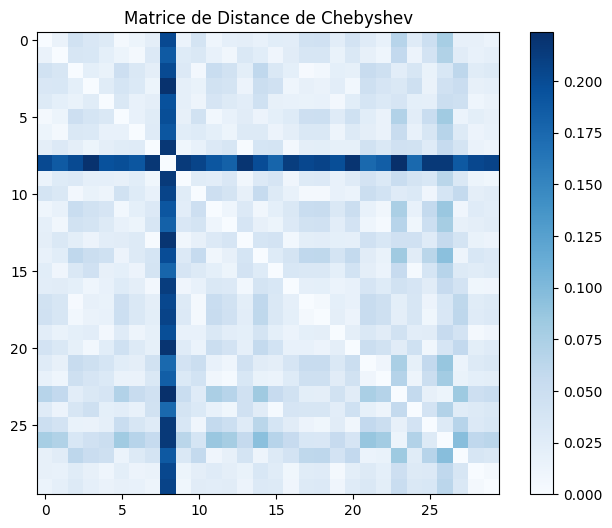

In [34]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Fonction pour calculer la distance de Chebyshev entre deux points
def chebyshev_distance(point1, point2):
    return np.max(np.abs(point1 - point2))

# Définir la taille de l'échantillon (par exemple, 30 nœuds)
sample_size = 30
indices = np.random.choice(len(df_selected), sample_size, replace=False)  # Tirage aléatoire sans répétition

# Sous-échantillonner les données (par exemple, latitude et longitude des points)
data_sample = df_selected.iloc[indices][['pickup_longitude', 'pickup_latitude']].values

# Calculer la matrice de distances de Chebyshev
chebyshev_matrix = np.zeros((sample_size, sample_size))  # Matrice carrée (sample_size x sample_size)

for i in range(sample_size):
    for j in range(i + 1, sample_size):
        distance = chebyshev_distance(data_sample[i], data_sample[j])
        chebyshev_matrix[i, j] = distance
        chebyshev_matrix[j, i] = distance  # Symétrie de la distance

# Appliquer un algorithme de clustering (par exemple, KMeans) pour calculer le score de silhouette
kmeans = KMeans(n_clusters=3, random_state=42)  # Choisir un nombre de clusters, ici 3
labels = kmeans.fit_predict(data_sample)

# Calculer le score de silhouette
silhouette_avg = silhouette_score(data_sample, labels, metric='euclidean')  # Utilisation de la distance euclidienne pour le clustering
print(f"Score de Silhouette moyen : {silhouette_avg}")

# Optionnel : Dessiner la matrice de distance de Chebyshev
plt.figure(figsize=(8, 6))
plt.imshow(chebyshev_matrix, cmap='Blues', interpolation='nearest')
plt.title("Matrice de Distance de Chebyshev")
plt.colorbar()
plt.show()


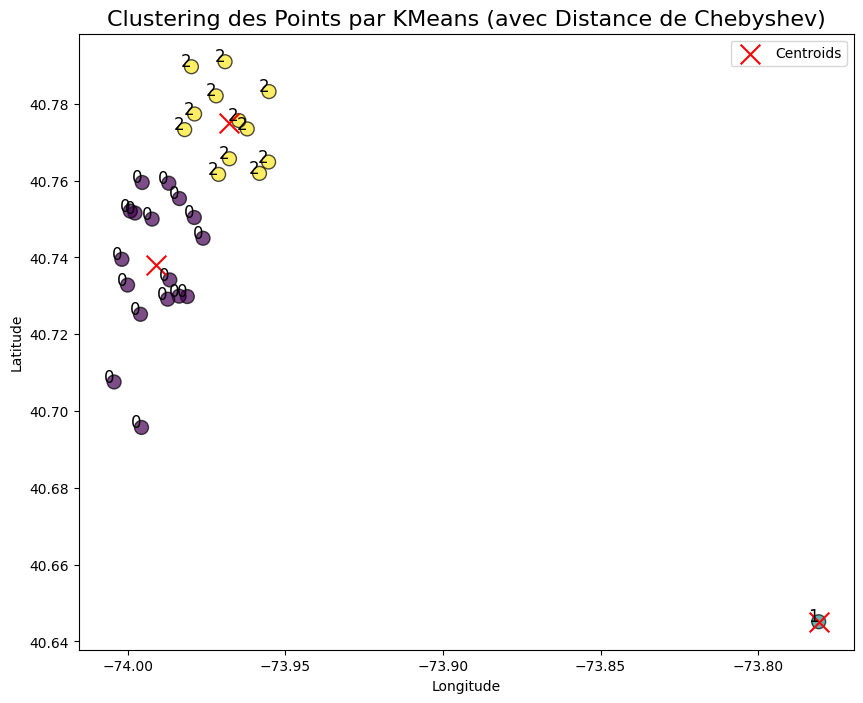

In [35]:


# Afficher les clusters sur un graphique
plt.figure(figsize=(10, 8))

# Utiliser différentes couleurs pour chaque cluster
plt.scatter(data_sample[:, 0], data_sample[:, 1], c=labels, cmap='viridis', marker='o', s=100, edgecolors='k', alpha=0.7)

# Ajouter les centroids (les centres des clusters)
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')

# Ajouter les labels pour les clusters (optionnel)
for i, label in enumerate(labels):
    plt.text(data_sample[i, 0], data_sample[i, 1], str(label), fontsize=12, ha='right', color='black')

# Configurer le titre et les axes
plt.title("Clustering des Points par KMeans (avec Distance de Chebyshev)", fontsize=16)
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Afficher la légende
plt.legend()

# Afficher le graphique
plt.show()


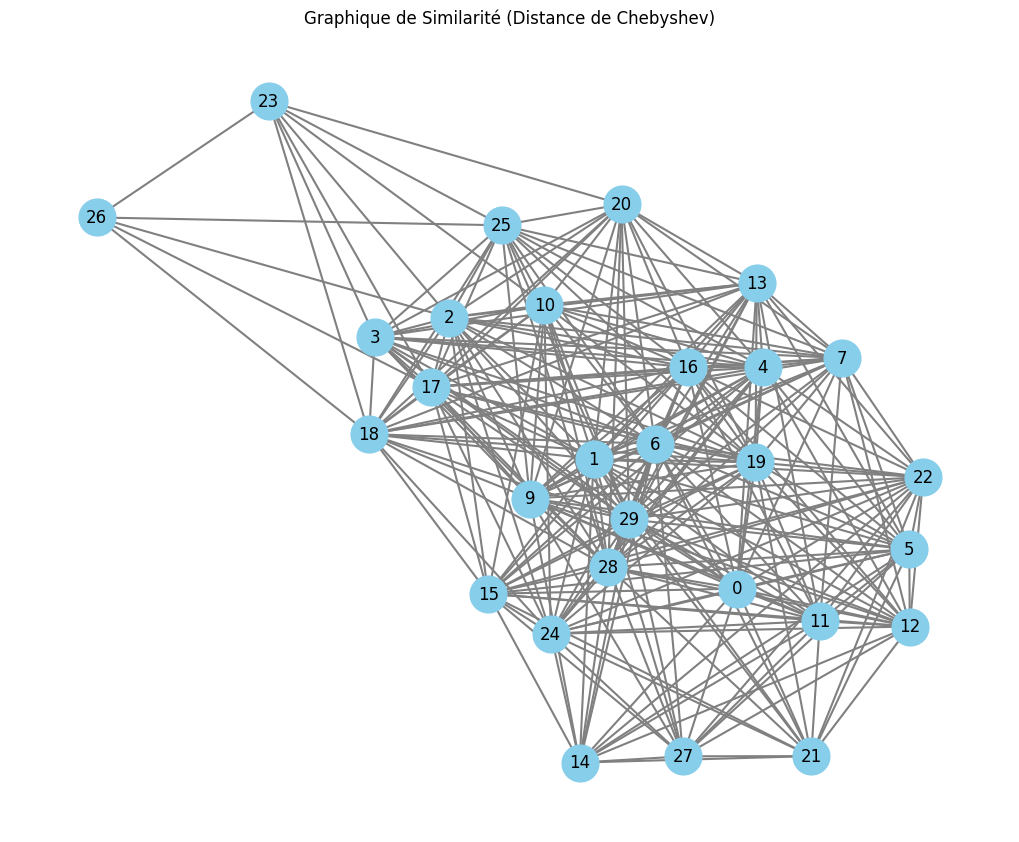

In [36]:
# Créer un graphe basé sur la matrice de distances de Chebyshev
G = nx.Graph()
for i in range(sample_size):
    for j in range(i + 1, sample_size):
        if chebyshev_matrix[i][j] < seuil:
            G.add_edge(i, j, weight=chebyshev_matrix[i][j])

# Dessiner le graphe de similarité
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)  # Layout pour l'organisation des nœuds
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray', width=1.5)
plt.title("Graphique de Similarité (Distance de Chebyshev)")
plt.show()